### 第一个人工智能程序_01

下面我将手把手教大家编写第一个人工智能程序！用它可以识别出一张图片中是否有猫。如你如见，我们是在Jupyter Notebook环境中进行编程的，因为它既可以编写/执行代码又可以像文档一样写文章，很适合教学。

首先我们先加载一些工具库。

In [2]:
import numpy as np # 加载numpy工具库并给它取个别名为np，后面就可以通过np来调用numpy工具库里面的函数了。numpy是python的一个科学计算工具库，
                    # 除了前面文章中提到的它可以用来进行向量化之外，它还有很多常用的功能。非常非常常用的一个工具库！
import matplotlib.pyplot as plt # 这个库是用来画图的

import h5py # 这个库是用来加载训练数据集的。我们数据集的保存格式是HDF。Hierarchical Data Format(HDF)是一种针对大量数据进行组织和存储的
            #  文件格式,大数据行业和人工智能行业都用它来保存数据。
import skimage.transform as tf # 这里我们用它来缩放图片

#这是jupyter notebook里的命令, 意思是将那些用matplotlib绘制的图显示在页面里而不是弹出一个窗口
%matplotlib inline 

ImportError: No module named numpy

In [ ]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r") # 加载训练数据
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # 从训练数据中提取出图片的特征数据
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # 从训练数据中提取出图片的标签数据

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r") # 加载测试数据
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:]) # 加载标签类别数据，这里的类别只有两种，1代表有猫，0代表无猫
        
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0])) # 把数组的维度从(209,)变成(1, 209)，这样好方便后面进行计算
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0])) # 从(50,)变成(1, 50)
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

Error: Jupyter cannot be started. Error attempting to locate jupyter: 

In [7]:
# 调用上面定义的函数将数据加载到各个变量中
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

能看到这篇文章了，相信你前面的文章已经都看了，那么也就知道了人工智能是需要用很多数据来进行训练的。

我已经为大家准备好了数据。文档同目录下的datasets文件夹就是存放数据集的地方。

下面这个函数用于加载这些数据。

下面我们随便挑一张图片将其显示出来，给大家一个直观的认识。下面的index你们可以随便改动。图片的像素很低，是因为如果用高像素图片的话就会需要更多的计算时间。我的目的只是教学，所以没有必要用高像素的图片。

标签为[0], 这是一个'non-cat' 图片.


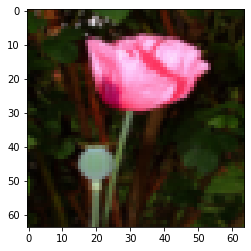

In [8]:
index = 30
plt.imshow(train_set_x_orig[index])
print ("标签为" + str(train_set_y[:, index]) + ", 这是一个'" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' 图片.")

In [9]:
# 我们要清楚变量的维度，否则后面会出很多问题。下面我把他们的维度打印出来。
print ("train_set_x_orig shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_orig shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_orig shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x_orig shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


上面train_set_x_orig的各维度的含义分别是(样本数，图片宽，图片长，3个RGB通道)

我们后面要用到样本数和长宽像素值，下面我分别把它们提取出来了。

In [10]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = test_set_x_orig.shape[1] # 由于我们的图片是正方形的，所以长宽相等

print ("训练样本数: m_train = " + str(m_train))
print ("测试样本数: m_test = " + str(m_test))
print ("每张图片的宽/高: num_px = " + str(num_px))

训练样本数: m_train = 209
测试样本数: m_test = 50
每张图片的宽/高: num_px = 64


In [11]:
# 为了方便后面进行矩阵运算，我们需要将样本数据进行扁平化和转置
# 处理后的数组各维度的含义是（图片数据，样本数）

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T 

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))

train_set_x_flatten shape: (12288, 209)
test_set_x_flatten shape: (12288, 50)


In [12]:
# 下面我们对特征数据进行了简单的标准化处理（除以255，使所有值都在[0，1]范围内）
# 为什么要对数据进行标准化处理呢？简单来说就是为了方便后面进行计算，详情以后再给大家解释

train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

上面我们已经加载了数据，并且对数据进行了预处理，使其便于进行后面的运算。
后面我们将会构建一个如下图所示的神经网络模型来对上面的数据进行运算。

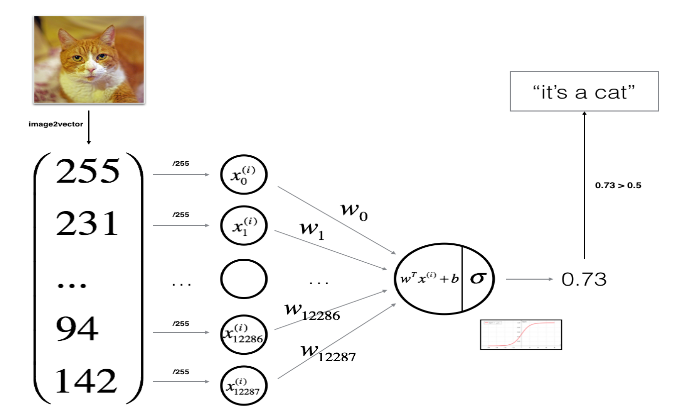

为了构建上面的神经网络，我们需要先编写一些工具函数，这些函数会对上面的数据进行特定功能的运算。最后再将这些单独的函数组合起来，构建出一个神经网络模型。

第一个编写的工具函数是sigmoid。前面文章我已经介绍过它了，sigmoid函数的作用就是把预测结果转换为0和1之间的值，不明白的复习下前面的文章。

下面是sigmoid的数学公式和图示。
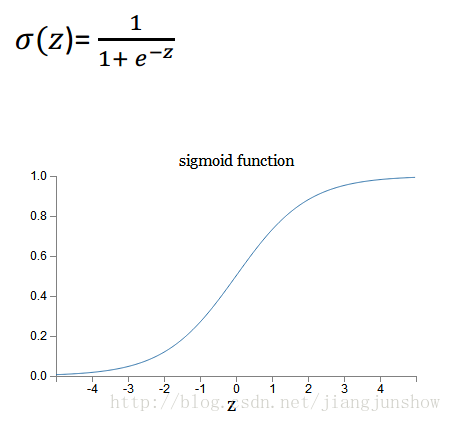

In [13]:
def sigmoid(z):
    """
    参数:
    z -- 一个数值或者一个numpy数组.
    返回值:
    s -- 经过sigmoid算法计算后的值，在[0,1]范围内
    """
    s = 1 / (1 + np.exp(-z))    
    return s

In [14]:
def initialize_with_zeros(dim):
    """
    这个函数用于初始化权重数组w和偏置/阈值b.
    
    参数:
    dim -- w的大小，看上面的神经网络模型图可知，dim在本例中是12288，因为一个特征输入对应一个权重。
    
    返回值:
    w -- 权重数组
    b -- 偏置bias
    """

    w = np.zeros((dim,1))
    b = 0
    
    return w, b

下面的函数用于执行前向传播，计算出成本cost；以及执行反向传播，计算出w和b的偏导数/梯度，后面会被用来进行梯度下降。

前向传播会用到下面两个公式：
- $$A = \sigma(w^TX+b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$$
- $$J = - \frac{1}{m}\sum_{i = 1}^{m} y^{(i)} log(a^{(i)}) + (1-y)^{(i)} log(1-a^{(i)})$$

反向传播会用到下面两个公式，计算dw和db：
- $$\frac{∂J}{∂w}=\frac{1}{m}X(A-Y)^T$$
- $$\frac{∂J}{∂b}=\frac{1}{m} \sum_{i = 1}^{m}(a^{(i)} - y^{(i)})$$

In [15]:
def propagate(w, b, X, Y):
    """
    参数:
    w -- 权重数组，维度是(12288, 1)
    b -- 偏置bias
    X -- 图片的特征数据，维度是 (12288, 209)
    Y -- 图片对应的标签，0或1，0是无猫，1是有猫，维度是(1,209)

    返回值:
    cost -- 成本
    dw -- w的梯度
    db -- b的梯度
    """
    
    m = X.shape[1]
    
    # 前向传播
    A = sigmoid(np.dot(w.T, X) + b)                             
    cost = -np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)) / m  
    
    # 反向传播
    dZ = A - Y
    dw = np.dot(X,dZ.T) / m
    db = np.sum(dZ) / m
    
    # 将dw和db保存到字典里面
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

下面的函数通过梯度下降算法来更新参数w和b，达到越来越优化的目的。

In [16]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """    
    参数:
    w -- 权重数组，维度是 (12288, 1)
    b -- 偏置bias
    X -- 图片的特征数据，维度是 (12288, 209)
    Y -- 图片对应的标签，0或1，0是无猫，1是有猫，维度是(1,209)
    num_iterations -- 指定要优化多少次
    learning_rate -- 学习步进，是我们用来控制优化步进的参数
    print_cost -- 为True时，每优化100次就把成本cost打印出来,以便我们观察成本的变化
    
    返回值:
    params -- 优化后的w和b
    costs -- 每优化100次，将成本记录下来，成本越小，表示参数越优化
    """
    
    costs = []
    
    for i in range(num_iterations):        
        grads, cost = propagate(w, b, X, Y) # 计算得出梯度和成本
                
        # 从字典中取出梯度
        dw = grads["dw"]
        db = grads["db"]
        
        # 进行梯度下降，更新参数，使其越来越优化，使成本越来越小
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # 将成本记录下来
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print ("优化%i次后成本是: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    return params, costs

上面的函数会得出优化后的参数w和b。训练神经网络，其实就是通过使用海量数据来进行训练，从而得出这些优化后的参数。有了这些参数后，我们就可以使用它们来进行预测了，对于本文章来说，也就是可以用这些参数来对新的任意图片进行预测了——预测图片里有猫或没有猫——最后面会告诉大家如何来预测你自己提供的任意图片。

下面这个函数会使用输入的参数w和b来对输入的待预测数据X进行预测。X可以是一张图片也可以是多张图片，当多张图片时，函数会给出对每张图片的预测结果。

In [17]:
def predict(w, b, X):
    '''    
    参数:
    w -- 权重数组，维度是 (12288, 1)
    b -- 偏置bias
    X -- 图片的特征数据，维度是 (12288, 图片张数)
    
    返回值:
    Y_prediction -- 对每张图片的预测结果
    '''    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
       
    A = sigmoid(np.dot(w.T, X) + b)  # 通过这行代码来对图片进行预测
    
    # 上面得出的预测结果是小数的形式，为了方便后面显示，我们将其转换成0和1的形式（大于等于0.5就是1/有猫，小于0.5就是0/无猫）
    for i in range(A.shape[1]):
        if A[0,i] >= 0.5:
            Y_prediction[0,i] = 1
    
    return Y_prediction

到此，我们已经编写了所需的所有工具函数了。下面我们将这些函数组合起来，构建出一个最终的神经网络模型函数。

In [18]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """    
    参数:
    X_train -- 训练图片,维度是(12288, 209)
    Y_train -- 训练图片对应的标签,维度是 (1, 209)
    X_test -- 测试图片,维度是(12288, 50)
    Y_test -- 测试图片对应的标签,维度是 (1, 50)
    num_iterations -- 需要训练/优化多少次
    learning_rate -- 学习步进，是我们用来控制优化步进的参数
    print_cost -- 为True时，每优化100次就把成本cost打印出来,以便我们观察成本的变化
    
    返回值:
    d -- 返回一些信息
    """
    
    # 初始化待训练的参数
    w, b = initialize_with_zeros(X_train.shape[0])

    # 使用训练数据来训练/优化参数
    parameters, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # 从字典中分别取出训练好的w和b
    w = parameters["w"]
    b = parameters["b"]
    
    # 使用训练好的w和b来分别对训练图片和测试图片进行预测
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    
    # 打印出预测的准确率
    print("对训练图片的预测准确率为: {}%".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("对测试图片的预测准确率为: {}%".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [19]:
# 调用上面的模型函数对我们最开始加载的数据进行训练
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

优化0次后成本是: 0.693147
优化100次后成本是: 0.584508
优化200次后成本是: 0.466949
优化300次后成本是: 0.376007
优化400次后成本是: 0.331463
优化500次后成本是: 0.303273
优化600次后成本是: 0.279880
优化700次后成本是: 0.260042
优化800次后成本是: 0.242941
优化900次后成本是: 0.228004
优化1000次后成本是: 0.214820
优化1100次后成本是: 0.203078
优化1200次后成本是: 0.192544
优化1300次后成本是: 0.183033
优化1400次后成本是: 0.174399
优化1500次后成本是: 0.166521
优化1600次后成本是: 0.159305
优化1700次后成本是: 0.152667
优化1800次后成本是: 0.146542
优化1900次后成本是: 0.140872
对训练图片的预测准确率为: 99.04306220095694%
对测试图片的预测准确率为: 70.0%


从上面打印出的信息可知，随着优化的次数越来越多，成本越来越小，说明优化后的参数使预测越来越准确了。
对于训练图片的预测准确率达到了99%。
对于测试图片是70%，其实已经很不错了，因为出于教学的目的，我们的训练数据集很小，而且构建的是最最简单的单神经元神经网络，后面我会教大家构建更加强大更加复杂的神经网络的！

这张图的标签是 0, 预测结果是 0


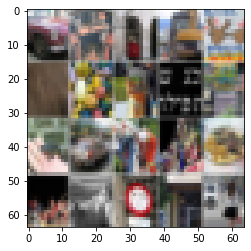

In [20]:
# 这里我们可以改变index，来看看哪些图片预测对了
index = 38
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("这张图的标签是 " + str(test_set_y[0,index]) + ", 预测结果是 " + str(int(d["Y_prediction_test"][0,index])))

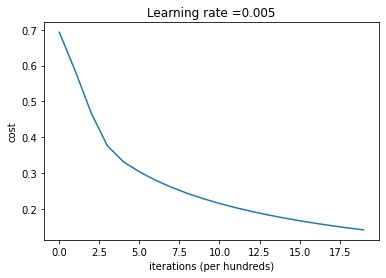

In [21]:
# 下面我们打印出成本随着训练次数增加时的变化情况。可以很直观的看出，训练次数越多，成本越小，也就是预测结果更精确
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost') # 成本
plt.xlabel('iterations (per hundreds)') # 横坐标为训练次数，以100为单位
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

选择一个正确的学习步进/学习率很重要。选错了，那么你的神经网络可能会永远找不到损失函数的最小值处，即你的神经网络预测得永远不会很准。下面我使用了3个不同的学习率来给大家直观地展示展示它们对训练过程的影响。

学习率为: 0.01时
对训练图片的预测准确率为: 99.52153110047847%
对测试图片的预测准确率为: 68.0%

-------------------------------------------------------

学习率为: 0.001时
对训练图片的预测准确率为: 88.99521531100478%
对测试图片的预测准确率为: 64.0%

-------------------------------------------------------

学习率为: 0.0001时
对训练图片的预测准确率为: 68.42105263157895%
对测试图片的预测准确率为: 36.0%

-------------------------------------------------------



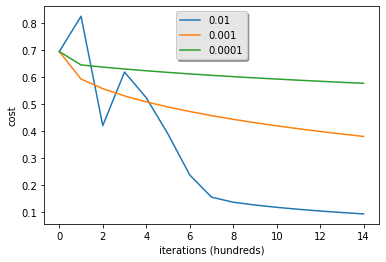

In [22]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("学习率为: " + str(i) + "时")
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

可以看到，上面其它的代码都是一样的，只有学习率不同，就会导致预测的准确率不同。在以后的文章中，我会教大家如何选择合适的学习率。

到此，你已经学会了构建一个最简单的神经网络了。看懂了本篇文章，那就说明你已经入门人工智能领域了。恭喜恭喜！

下面的代码向大家展示了如何使用上面构建的神经网络来预测我们自己的图片。

预测结果为 1


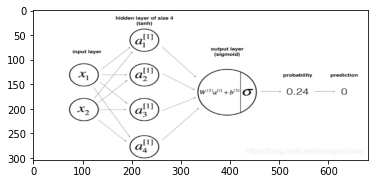

In [23]:
# 在�����文档的同目录下创建一个文件夹images,把你的任意图片改名成my_image1.jpg后放入文件夹
my_image = "TIM图片20180813112914.png" 
fname = "images/" + my_image

image = np.array(plt.imread(fname))
my_image = tf.resize(image,(num_px,num_px), mode='reflect').reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("预测结果为 " + str(int(np.squeeze(my_predicted_image))))

上面我给的文件不是一只猫，而是一个女优，所以我们的神经网络的预测结果为0。

你已经入门人工智���领域了，后面的教程我会教大家构建更强大的人工智能程序。

庆祝庆祝吧！借着上面图片带来的激情去释放一下吧！爽！！